## 这是用来测试 PSO 后的参数是否能够成功模拟出路径

In [153]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from shapely import Point, LineString
import random
from enum import Enum

In [154]:
opti_path = '../PSO_opt_result/opt2/pso_result.csv'
real_swath_path = '../Scratch/test_Load_Shp/test_shps/swath_group_1.shp'
straight_swath_path = 'GIS_data/straight_swaths/straight_swaths.shp'
opti_parameters = pd.read_csv(opti_path)
real_swath = gpd.read_file(real_swath_path)
straight_swath = gpd.read_file(straight_swath_path)
print(opti_parameters.shape)
print(len(straight_swath), end=' ')
print(len(real_swath))

(300, 4)
28 28


In [155]:
# 提取地形图
with rasterio.open('GIS_data/路径规划优化用数据/2m_pClouds_regen_dem_cm.tif') as dem_src:
    dem_array = dem_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Aspect_clip_pcGen_2m_cm1.tif') as aspect_src:
    aspect_array = aspect_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif') as slope_src:
    slope_array = slope_src.read(1)
[dem_array.shape, aspect_array.shape, slope_array.shape]

[(507, 440), (507, 440), (507, 440)]

0.2663901632725485


<AxesSubplot: title={'center': 'lambda x  lambda y'}>

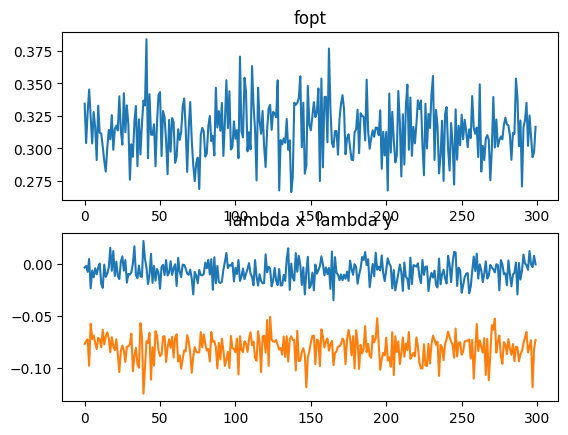

In [156]:
# 显示优化的 fopt
print(opti_parameters['2'].min())
plt.subplot(211)
plt.title('fopt')
opti_parameters['2'].plot()
plt.subplot(212)
plt.title('lambda x  lambda y')
opti_parameters['0'].plot()
opti_parameters['1'].plot()

In [157]:
# 找到最优 foptimal 的索引，取出其 xoff yoff 的参数
optimal_params = opti_parameters.iloc[opti_parameters['2'].idxmin()]
# optimal_params = opti_parameters.iloc[40]
optimal_params[1:]

0   -0.000072
1   -0.069554
2    0.266390
Name: 137, dtype: float64

In [158]:
best_lambda_x, best_lambda_y = optimal_params[1], optimal_params[2]
print(best_lambda_x, best_lambda_y)

-7.179150038363083e-05 -0.0695538379489731


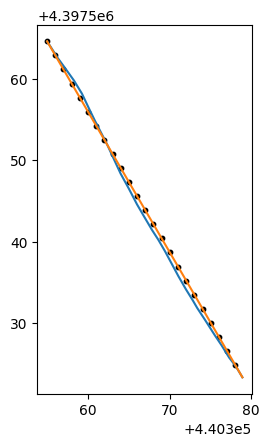

In [159]:
# 随机选择一个点进行采样和模拟
sample_ind = random.randint(0, len(real_swath))
sample_real_land = real_swath.geometry.iloc[sample_ind]
sample_straight_land = straight_swath.geometry.iloc[sample_ind]
# 采样
sample_points = np.arange(0, sample_real_land.length, 2)
sample_points = [sample_straight_land.interpolate(sample_point) for sample_point in sample_points]
# show
_, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(*sample_real_land.xy)
ax.plot(*sample_straight_land.xy)
for sample_point in sample_points:
    ax.scatter(*sample_point.xy, color='black', s=10)

In [160]:
# 取出当前位置上的地形信息
class raster(Enum):
    DEM = 1
    ASPECT = 2
    SLOPE = 3
def get_11_from_raster(point: Point, category):    
    if category == raster.SLOPE:
        temp_raster = slope_array
        temp_src = slope_src
    elif category == raster.ASPECT:
        temp_raster = aspect_array
        temp_src = aspect_src
    else:
        temp_raster = dem_array
        temp_src = dem_src
    row, col = temp_src.index(point.x, point.y)
    return temp_raster[row, col]

In [161]:
sample_points_data = []
for sample_point in sample_points:
    new_row = [
        sample_point.x, sample_point.y,
        get_11_from_raster(sample_point, category=raster.DEM),
        get_11_from_raster(sample_point, category=raster.ASPECT),
        get_11_from_raster(sample_point, category=raster.SLOPE)
    ]
    sample_points_data.append(new_row)

In [162]:
sample_points_data = np.array(sample_points_data)
sample_points_data

array([[4.40354944e+05, 4.39756459e+06, 2.04080000e+04, 7.66075058e+01,
        8.44169712e+00],
       [4.40355949e+05, 4.39756286e+06, 2.04090000e+04, 6.38412933e+01,
        1.11477852e+01],
       [4.40356954e+05, 4.39756114e+06, 2.03980000e+04, 7.82692261e+01,
        1.31501226e+01],
       [4.40357959e+05, 4.39755941e+06, 2.03400000e+04, 7.23953629e+01,
        7.76651096e+00],
       [4.40358964e+05, 4.39755768e+06, 2.03690000e+04, 5.11046829e+01,
        9.43791389e+00],
       [4.40359969e+05, 4.39755595e+06, 2.03540000e+04, 6.80968246e+01,
        1.10907726e+01],
       [4.40360974e+05, 4.39755422e+06, 2.03810000e+04, 7.03940735e+01,
        1.41146021e+01],
       [4.40361980e+05, 4.39755249e+06, 2.03270000e+04, 6.61940536e+01,
        1.05260324e+01],
       [4.40362985e+05, 4.39755076e+06, 2.03360000e+04, 5.12034492e+01,
        1.15571146e+01],
       [4.40363990e+05, 4.39754903e+06, 2.03670000e+04, 4.60741692e+01,
        8.05086327e+00],
       [4.40364995e+05, 4.3975

In [163]:
def model_fit(lambdas, data):
    print(data, '1')
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    x_off = lambdas[0] * np.cos(aspect) * slope
    y_off = lambdas[1] * np.sin(aspect) * slope
    
    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

In [164]:
simul_points = []
for point in sample_points_data:
    simul_points.append(model_fit(optimal_params[1:3], point))
print(simul_points[:3])
# optimal_params[:2]

[4.40354944e+05 4.39756459e+06 2.04080000e+04 7.66075058e+01
 8.44169712e+00] 1
[4.40355949e+05 4.39756286e+06 2.04090000e+04 6.38412933e+01
 1.11477852e+01] 1
[4.40356954e+05 4.39756114e+06 2.03980000e+04 7.82692261e+01
 1.31501226e+01] 1
[4.40357959e+05 4.39755941e+06 2.03400000e+04 7.23953629e+01
 7.76651096e+00] 1
[4.40358964e+05 4.39755768e+06 2.03690000e+04 5.11046829e+01
 9.43791389e+00] 1
[4.40359969e+05 4.39755595e+06 2.03540000e+04 6.80968246e+01
 1.10907726e+01] 1
[4.40360974e+05 4.39755422e+06 2.03810000e+04 7.03940735e+01
 1.41146021e+01] 1
[4.40361980e+05 4.39755249e+06 2.03270000e+04 6.61940536e+01
 1.05260324e+01] 1
[4.40362985e+05 4.39755076e+06 2.03360000e+04 5.12034492e+01
 1.15571146e+01] 1
[4.40363990e+05 4.39754903e+06 2.03670000e+04 4.60741692e+01
 8.05086327e+00] 1
[4.40364995e+05 4.39754730e+06 2.03280000e+04 6.74358902e+01
 8.43106651e+00] 1
[4.40366000e+05 4.39754557e+06 2.03420000e+04 9.86825256e+01
 7.31369162e+00] 1
[4.40367005e+05 4.39754384e+06 2.0336000

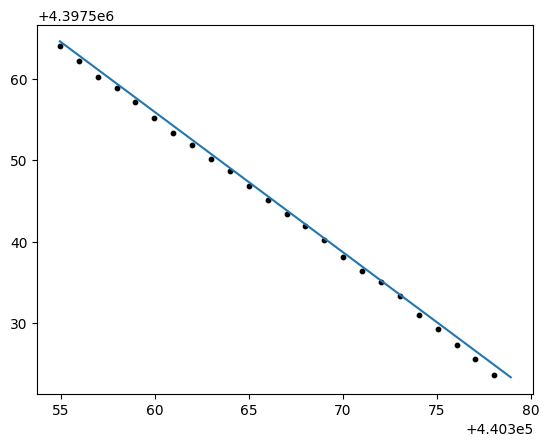

In [167]:
# 检测
simul_line = LineString(simul_points)
_, ax = plt.subplots()
# ax.set_aspect('equal')
# ax.plot(*simul_line.xy)
for point in simul_points:
    ax.scatter(*point.xy, color='black', s=10)
# ax.plot(*sample_real_land.xy, linewidth=1)
ax.plot(*sample_straight_land.xy)

[440345.93409065274, 4397532.697626984, 20581, 98.36588, 7.343308] 1
[440346.9233389104, 4397530.959412991, 20549, 106.4293, 5.804205] 1
[440347.9125871681, 4397529.221198998, 20545, 105.395546, 5.1120825] 1
[440348.8950071073, 4397527.479129707, 20528, 105.61099, 5.043609] 1
[440349.87235761463, 4397525.734198195, 20523, 113.96249, 5.62484] 1
[440350.85890705744, 4397523.9945360385, 20491, 104.23728, 4.938311] 1
[440351.8696663319, 4397522.268741819, 20493, 126.34746, 4.7021885] 1
[440352.8804256064, 4397520.542947599, 20484, 127.11686, 3.319467] 1
[440353.88818599714, 4397518.815427423, 20464, 141.41084, 4.526132] 1
[440354.8726419557, 4397517.074494781, 20446, 112.724106, 4.5328703] 1
[440355.8570979142, 4397515.3335621385, 20443, 96.1155, 4.027015] 1
[440356.83934801986, 4397513.591386512, 20426, 82.43857, 4.0751247] 1
[440357.8185642975, 4397511.847501343, 20434, 87.563354, 3.365298] 1
[440358.7977805752, 4397510.103616174, 20420, 97.43141, 3.318698] 1
[440359.7755972639, 4397508.

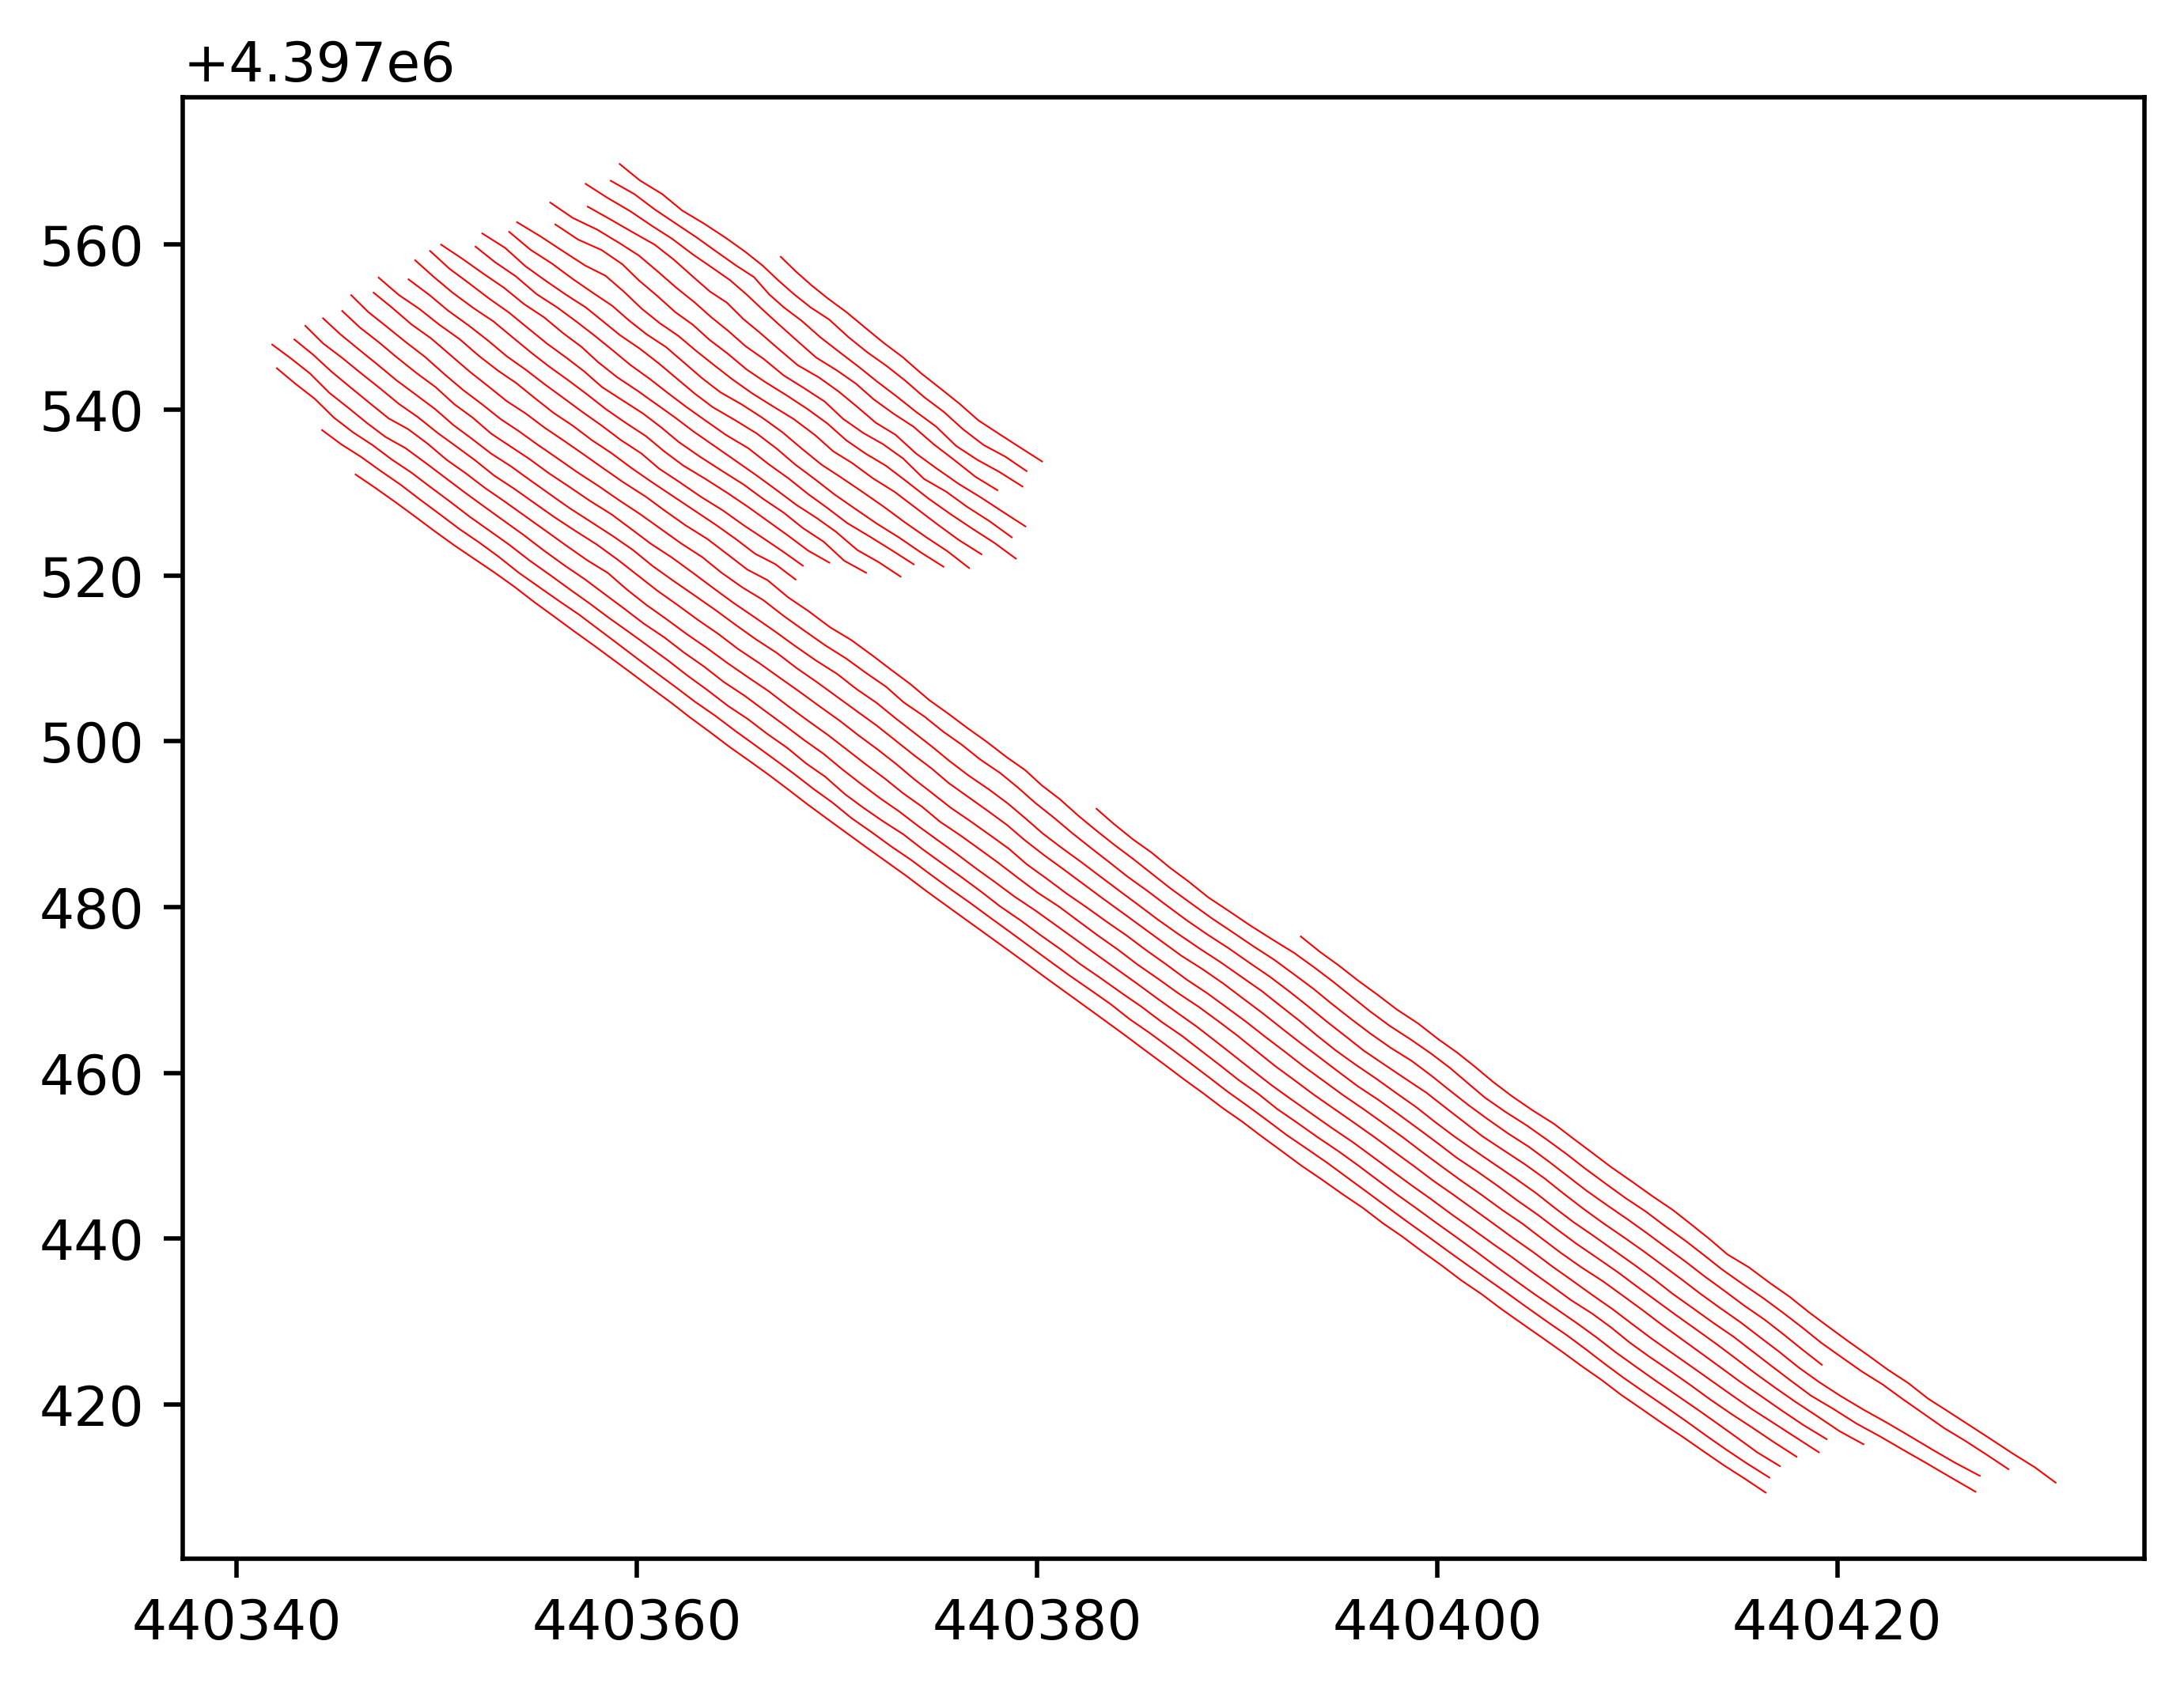

In [184]:
# 查看所有的路径
_, ax = plt.subplots(dpi=500)
sample_accuracy = 2
for temp_real_line, temp_straight_line in zip(real_swath.geometry, straight_swath.geometry):
    samples = np.arange(0, temp_real_line.length, sample_accuracy)
    # temp_sample_points = [temp_real_line.interpolate(sample) for sample in samples]
    temp_result_points = []
    for i, sample in enumerate(samples):
        # if i == 0:
        #     temp_result_points.append(temp_straight_line.coords[0])
        # if i == len(samples) - 1:
        #     temp_result_points.append(temp_straight_line.coords[-1])
        temp_sample_point = temp_real_line.interpolate(sample)
        temp_point_data = [
            temp_sample_point.x, temp_sample_point.y,
            get_11_from_raster(temp_sample_point, raster.DEM),
            get_11_from_raster(temp_sample_point, raster.ASPECT),
            get_11_from_raster(temp_sample_point, raster.SLOPE)
        ]
        temp_result_points.append(model_fit(optimal_params[1:3], temp_point_data))
    temp_modi_line = LineString(temp_result_points)
    ax.plot(*temp_modi_line.xy, color='red', linewidth=0.3)
# straight_swath.plot(ax=ax, color='black', linewidth=0.3)
# real_swath.plot(ax=ax, color='g', linewidth=0.4)